In [1]:
import os
import pandas as pd
import actr
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

ACT-R connection has been started.


In [8]:
class MiniModel:
    def __init__(self, num_productions=10, param_set=None):
        self.curr_index = 0
        self.curr_onset = 0
        self.curr_offset = 0
        self.curr_production = ""
        self.ordered_productions = ["P"+str(i+1) for i in range(num_productions)]
        self.production_at = np.arange(1, num_productions+1)/100
        self.production_reward = range(num_productions)
        
        self.trial_trace = []
        self.production_trace = []
        self.reward_trace = []
        self.utility_trace = []
        
        self.param_set = param_set
    
    def setup_model(self, model="mini-model.lisp", retrieve=False):
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        actr.load_act_r_model(os.path.join(curr_dir, model))
        if retrieve:
            actr.pdisable('skip-retrieval')
        else:
            actr.pdisable('retrieve-rule')
        self.setup_parameters()
    
    def cost_function(self, x, c=1.5, enable=True):
        c = np.exp(x*c)-1
        if enable:
            return np.round(c, 4)
        else:
            return x

    def payoff_function(SELF, x, l=10, k=1, x0=5, enable=True):
        """
        sigmoid function
            x0 = mid point
            l = max 
            k = slope
        """
        r = l / (1 + np.exp(-k * ( x - x0)))
        if enable:
            return np.round(r, 4)
        else: 
            return x
        
    def setup_parameters(self):
        actr.hide_output()
        # set at parameter
        
        # set difficulty level
        x0 = 5
        if self.param_set and 'difficulty' in self.param_set.keys():
            #print('set difficulty level')
            x0 = self.param_set['difficulty']

        self.production_at = [self.cost_function(x) for x in self.production_at]
        self.production_reward = [self.payoff_function(x, x0=x0) for x in self.production_reward]
        
        for i in range(len(self.ordered_productions)):
            actr.spp(self.ordered_productions[i], ":at", self.production_at[i], ":reward", self.production_reward[i])
        #actr.spp("DONE", ":reward", 1)
        actr.unhide_output() 
        

    def production_hook(self, *params):
        #print('in p hook', params)
        production = params[0]
        if production == "START-TRIAL":
            self.curr_index += 1
            self.curr_onset = actr.mp_time()
        elif production == "DONE":
            self.curr_offset = actr.mp_time()
            self.trial_trace.append((self.curr_index, self.curr_production, np.round(self.curr_offset-self.curr_onset, 2)))
            #print(self.curr_index, self.curr_onset, self.curr_offset, self.curr_offset-self.curr_onset)
        elif production in self.ordered_productions:
            self.production_trace.append((self.curr_index, production, actr.mp_time()))
            self.curr_production = production
        return production
    
    def reward_hook(self, *params):
        production = params[0]
        delivered_reward = params[1]
        discounted_reward = params[2]
        if production in self.ordered_productions:
            #print('in reward hook', production)
            self.reward_trace.append((self.curr_index, production, actr.mp_time(), delivered_reward, discounted_reward))
        return (params)

    def utility_hook(self, *params):
        #print('u', len(params), params)
        # NEW: record the production utility
        #self.current_trial.utility_trace=[self.extract_production_parameter('PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('PROCESS-LOCATION', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-LOCATION', ':u')]
        #print(self.extract_production_parameter('P1', ':u'))
        pass
          
    def extract_production_parameter(self, epoch):
        """
        This function will extract the parameter value of a production during model running
        """
        #assert (production_name in actr.all_productions() and
        #        parameter_name in [':u', ':utility', ':at', ':reward', ':fixed-utility'])
        utility_trace = []
        actr.hide_output()
        for production_name in self.ordered_productions:
            u = actr.spp(production_name, ":u")[0][0]
            utility = actr.spp(production_name, ":utility")[0][0]
            reward = actr.spp(production_name, ":reward")[0][0]
            utility_trace.append((epoch, production_name, u, utility, reward))
        actr.unhide_output()
        return pd.DataFrame(utility_trace, columns=['epoch','production', 'u', 'utility', 'delivered_reward'])
    
    def df_trace_output(self):
        df_trial_trace = pd.DataFrame(self.trial_trace, columns=['trial', 'production', 'response_time'])
        df_production_trace = pd.DataFrame(self.production_trace, columns=['trial', 'production', 'firing_time'])
        df_reward_trace = pd.DataFrame(self.reward_trace, columns=['trial', 'production', 'rewarded_time', 'delivered_reward', 'passed_time'])
        df_reward_trace['received_reward'] = df_reward_trace['delivered_reward']-df_reward_trace['passed_time']
        df_cost = pd.DataFrame(list(zip(self.ordered_productions, self.production_at)), columns=["production", "at"])
        df_utility_trace = pd.merge(self.utility_trace, df_cost)
        return pd.merge(pd.merge(pd.merge(df_trial_trace, df_production_trace, on=['trial', 'production']),df_reward_trace, on=['trial', 'production']), df_utility_trace, on=["production", "delivered_reward"]).drop_duplicates()
        #return (df_trial_trace, df_production_trace, df_reward_trace, df_utility_trace)
        
    def experiment(self, time=100):
        actr.add_command("production-hook",self.production_hook)
        actr.add_command("reward-hook", self.reward_hook)
        actr.add_command("utility-hook", self.utility_hook)
        actr.schedule_event_relative(0.01, "production-hook")
        actr.schedule_event_relative(0.01, "reward-hook")
        actr.schedule_event_relative(0.01, "utility-hook")

        self.setup_model()
        actr.run(time)
        actr.remove_command("production-hook")
        actr.remove_command("reward-hook")
        actr.remove_command("utility-hook")

def simulation(epoch=1, time=100, param_set=None):
    simulated_results = []
    for i in range(epoch):
        if i%10 == 0: print("==== SIMULATED ==== epoch >>", i)
        m = MiniModel(param_set=param_set)
        m.experiment(time=time)
        
        # record utility
        m.utility_trace = m.extract_production_parameter(i)
        simulated_results.append(m)
    return simulated_results

In [9]:
m = MiniModel(param_set={'difficulty':5})
print()
m.experiment(1)

## Simulate Model

Task difficulty = LOW

In [12]:
simulated_results_low = simulation(epoch=10, time=1, param_set={'difficulty':5})

==== SIMULATED ==== epoch >> 0
Command  production-hook  already exists and is now being replaced by  <bound method MiniModel.production_hook of <__main__.MiniModel object at 0x7fc41dbb0790>>
Command  reward-hook  already exists and is now being replaced by  <bound method MiniModel.reward_hook of <__main__.MiniModel object at 0x7fc41dbb0790>>
Command  utility-hook  already exists and is now being replaced by  <bound method MiniModel.utility_hook of <__main__.MiniModel object at 0x7fc41dbb0790>>


Task difficulty = HIGH

In [13]:
simulated_results_high = simulation(epoch=10, time=1, param_set={'difficulty':7})

==== SIMULATED ==== epoch >> 0


## Clean Data 

In [30]:
def merge_simulation_data(simulated_results):
    n = len(simulated_results)
    dfs = [simulated_results[i].df_trace_output() for i in range(n)]
    df = pd.concat(dfs, axis=0)
    
    # shift column 'epoch' to first position
    first_column = df.pop('epoch')
    df.insert(0, 'epoch', first_column)
    df.sort_values(['epoch', 'trial'], inplace=True)
    return df

In [32]:
df1 = merge_simulation_data(simulated_results_low)
df2 = merge_simulation_data(simulated_results_high)

## Visualize Data

In [36]:
def plot_actr_evc1(df1):
    order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
    fig, ax = plt.subplots(1,4, figsize=(15,4))
    fig.suptitle("Simulation results: N = {}".format(len(df1)))
    sns.pointplot(x="production", y="at", order=order, data=df1, palette="Greens", ax=ax[0]).set_title('Cost of Productions')
    sns.pointplot(x="production", y="received_reward", data=df1, order=order, palette="Reds", ax=ax[1]).set_title('Reward of Productions')
    sns.countplot(x=df1['production'], order=order, palette="Purples", ax=ax[2]).set_title('Distribution of Productions')
    sns.lineplot(x="production", y="u", color="purple", data=df1, ax=ax[3]).set_title('Utility of Productions')
    plt.show()
    
def plot_actr_evc2(df1):
    order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    sns.countplot(x=df1['production'], order=order, palette="Purples", ax=ax).set_title('EVC in ACT-R')
    sns.pointplot(x="production", y="received_reward", data=df1, order=order, palette="Reds", ax=ax2)
    sns.pointplot(x="production", y="response_time", order=order, data=df1, palette="Blues", ax=ax3)
    sns.lineplot(x="production", y="u", color="purple", data=df1, ax=ax4)
    plt.show()

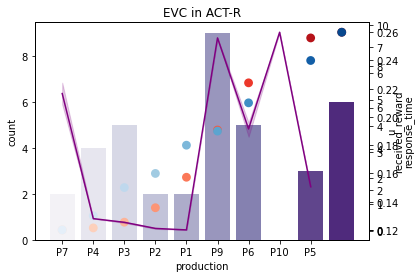

In [39]:
plot_actr_evc2(df1)

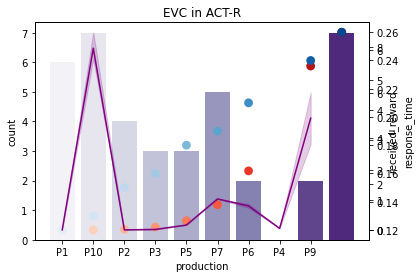

In [40]:
plot_actr_evc2(df2)

In [6]:
def merge_simulation_data(simulated_results):
    n = len(simulated_results)
    df1s = []
    df2s = []
    df3s = []
    df4s = []
    for i in range(n):
        df = simulated_results[i].df_trace_output()
        df1s.append(df1)
        df2s.append(df2)
        df3s.append(df3)
        df4s.append(df4) # utility trace after each simulation
    df1 = pd.concat(df1s, axis=0)
    df2 = pd.concat(df2s, axis=0)
    df3 = pd.concat(df3s, axis=0)
    df4 = pd.concat(df4s, axis=0)
    return df1, df2, df3, df4

In [9]:
df1, df2, df3, df4 = merge_simulation_data(simulated_results_low)
df1.shape, df2.shape, df3.shape, df4.shape

((33, 3), (36, 3), (36, 6), (100, 6))

In [20]:
df1

,trial,production,response_time
0,1,P7,0.21
1,2,P7,0.21
2,3,P7,0.21
0,1,P10,0.26
1,2,P10,0.26
2,3,P10,0.26
0,1,P8,0.23
1,2,P8,0.23
2,3,P8,0.23
0,1,P6,0.19


In [26]:
pd.merge(pd.merge(pd.merge(df1, df2, on=['trial', 'production']),df3, on=['trial', 'production']), df4, on=["production", "delivered_reward"]).drop_duplicates()

,trial,production,response_time,firing_time,rewarded_time,delivered_reward,passed_time,received_reward,epoch,u,utility,at
0,1,P7,0.21,0.161,0.161,7.3106,0.111,7.1996,0,6.266532,6.471641,0.1107
1,1,P7,0.21,0.161,0.161,7.3106,0.111,7.1996,1,0.000000,-0.572346,0.1107
2,1,P7,0.21,0.161,0.161,7.3106,0.111,7.1996,2,0.000000,-0.439225,0.1107
3,1,P7,0.21,0.161,0.161,7.3106,0.111,7.1996,3,0.000000,-0.017624,0.1107
4,1,P7,0.21,0.161,0.161,7.3106,0.111,7.1996,4,0.000000,0.518609,0.1107
...,...,...,...,...,...,...,...,...,...,...,...,...
1945,4,P5,0.18,0.812,0.812,2.6894,0.078,2.6114,5,0.000000,-0.161011,0.0779
1946,4,P5,0.18,0.812,0.812,2.6894,0.078,2.6114,6,0.000000,0.827306,0.0779
1947,4,P5,0.18,0.812,0.812,2.6894,0.078,2.6114,7,2.272963,1.731187,0.0779
1948,4,P5,0.18,0.812,0.812,2.6894,0.078,2.6114,8,0.000000,0.261417,0.0779


In [ ]:
df1_low, df2_low, df3, df4 = merge_simulation_data(simulated_results_low)
df1_high, df2_high, df3_high, df4_high = merge_simulation_data(simulated_results_high)

In [5]:
df1.head()

,trial,production,response_time
0,1,P2,0.13
1,2,P7,0.21
2,3,P7,0.21
3,4,P7,0.21
0,1,P1,0.12


In [6]:
df2.head()

,trial,production,firing_time
0,1,P2,0.080
1,2,P7,0.341
2,3,P7,0.602
3,4,P7,0.863
0,1,P1,0.065


In [7]:
df3.head()

,trial,production,rewarded_time,delivered_reward,passed_time,received_reward
0,1,P2,0.080,0.1799,0.030,0.1499
1,2,P7,0.341,7.3106,0.111,7.1996
2,3,P7,0.602,7.3106,0.111,7.1996
3,4,P7,0.863,7.3106,0.111,7.1996
0,1,P1,0.065,0.0669,0.015,0.0519


In [8]:
df4.head()

,epoch,production,u,utility,delivered_reward,at
0,0,P1,0.00000,-1.643211,0.0669,0.0151
1,0,P2,0.05996,0.128858,0.1799,0.0305
2,0,P3,0.00000,0.172820,0.4743,0.0460
3,0,P4,0.00000,0.209461,1.1920,0.0618
4,0,P5,0.00000,-1.048037,2.6894,0.0779


In [9]:
save = False
suffix = ""#"_retrieval"
todays_date = date.today().strftime("%Y%m%d")
if save:
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    df1.to_csv(os.path.join(curr_dir, "mini_model_df1{}_{}.txt".format(suffix, todays_date)), index=False)
    df2.to_csv(os.path.join(curr_dir, "mini_model_df2{}_{}.txt".format(suffix, todays_date)), index=False)
    df3.to_csv(os.path.join(curr_dir, "mini_model_df3{}_{}.txt".format(suffix, todays_date)), index=False)
    df4.to_csv(os.path.join(curr_dir, "mini_model_df4{}_{}.txt".format(suffix, todays_date)), index=False)
else:
    try:
        df1 = pd.read_csv(os.path.join(curr_dir, "mini_model_df1{}_{}.txt".format(suffix, todays_date)))
        df2 = pd.read_csv(os.path.join(curr_dir, "mini_model_df2{}_{}.txt".format(suffix, todays_date)))
        df3 = pd.read_csv(os.path.join(curr_dir, "mini_model_df3{}_{}.txt".format(suffix, todays_date)))
        df4 = pd.read_csv(os.path.join(curr_dir, "mini_model_df4{}_{}.txt".format(suffix, todays_date)))
    except:
        print("No saved data!")

No saved data!


## Visualize Output

In [10]:
order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]


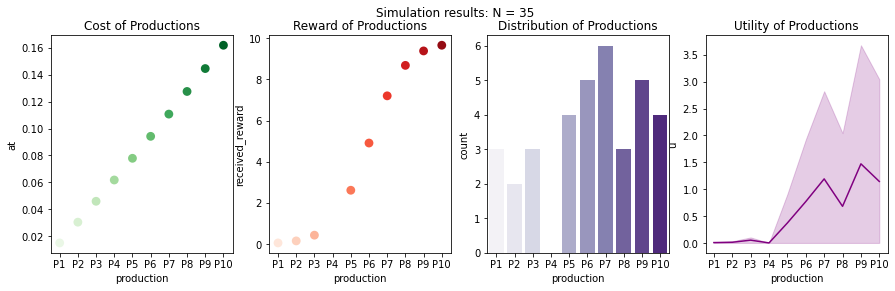

In [11]:
fig, ax =plt.subplots(1,4, figsize=(15,4))
fig.suptitle("Simulation results: N = {}".format(len(df1)))
sns.pointplot(x="production", y="at", order=order, data=df4, palette="Greens", ax=ax[0]).set_title('Cost of Productions')
sns.pointplot(x="production", y="received_reward", data=df3, order=order, palette="Reds", ax=ax[1]).set_title('Reward of Productions')
sns.countplot(x=df1['production'], order=order, palette="Purples", ax=ax[2]).set_title('Distribution of Productions')
sns.lineplot(x="production", y="u", color="purple", data=df4, ax=ax[3]).set_title('Utility of Productions')
plt.show()

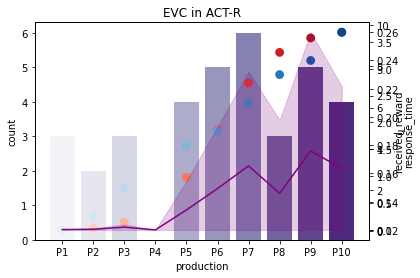

In [12]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

sns.countplot(x=df1['production'], order=order, palette="Purples", ax=ax).set_title('EVC in ACT-R')
sns.pointplot(x="production", y="received_reward", data=df3, order=order, palette="Reds", ax=ax2)
sns.pointplot(x="production", y="response_time", order=order, data=df1, palette="Blues", ax=ax3)
sns.lineplot(x="production", y="u", color="purple", data=df4, ax=ax4)
plt.show()

In [19]:
df1[['production', 'response_time']].groupby('production').agg(['mean', 'std'])

response_time     
                    mean  std
production                   
P1                  0.12  0.0
P10                 0.26  0.0
P2                  0.13  0.0
P3                  0.15  0.0
P5                  0.18  0.0
P6                  0.19  0.0
P7                  0.21  0.0
P8                  0.23  0.0
P9                  0.24  0.0

In [20]:
df3[['production', 'delivered_reward', 'received_reward']].groupby('production').agg(['mean', 'std'])

delivered_reward      received_reward     
                       mean  std            mean  std
production                                           
P1                   0.0669  0.0          0.0519  0.0
P10                  9.8201  0.0          9.6581  0.0
P2                   0.1799  0.0          0.1499  0.0
P3                   0.4743  0.0          0.4283  0.0
P5                   2.6894  0.0          2.6114  0.0
P6                   5.0000  0.0          4.9060  0.0
P7                   7.3106  0.0          7.1996  0.0
P8                   8.8080  0.0          8.6800  0.0
P9                   9.5257  0.0          9.3817  0.0

### Some Tests

In [22]:
def cost_function(x, c=1):
    return np.exp(x*c)-1
    #return x**c

def reward_function(x, l=10, k=1, x0=5):
    """
    x0 = middle point
    l = max 
    k = slope
    """
    s = l / (1 + np.exp(-k * ( x - x0)))
    return s

In [23]:
m=MiniModel()
reward = np.arange(10)
reward_trans = [reward_function(r, l=10, k=1, x0=5) for r in reward]

cost = np.arange(10)/100
cost_trans = [cost_function(x, c=1.5) for x in cost]
cost_trans

[0.0,
 0.01511306461571893,
 0.030454533953516938,
 0.04602785990871694,
 0.06183654654535964,
 0.07788415088463152,
 0.09417428370521042,
 0.11071061035570517,
 0.12749685157937574,
 0.14453678435131456]

(-0.0, 9.9)

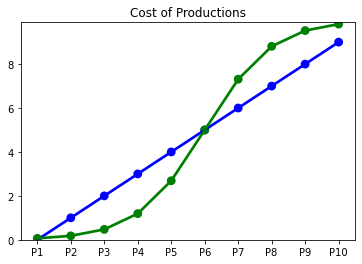

In [35]:
ax=sns.pointplot(x=m.ordered_productions, y=reward, color="blue", join=True, order=m.ordered_productions).set_title('Cost of Productions')
ax=sns.pointplot(x=m.ordered_productions, y=reward_trans, color="green", join=True, order=m.ordered_productions).set_title('Cost of Productions')
plt.ylim(min(reward)*-1.1, max(reward)*1.1)

(-0.0, 0.15899046278644602)

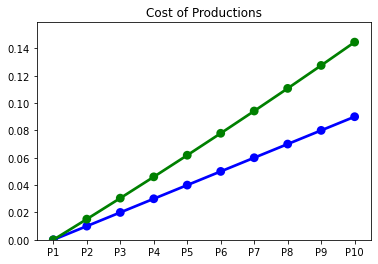

In [36]:
ax=sns.pointplot(x=m.ordered_productions, y=cost, color="blue", order=m.ordered_productions).set_title('Cost of Productions')
ax=sns.pointplot(x=m.ordered_productions, y=cost_trans, color="green", order=m.ordered_productions).set_title('Cost of Productions')
plt.ylim(min(cost)*-1.1, max(cost_trans)*1.1)